# Predicting Insurance Premiums Using Deep Learning

## 1. Problem description

In this project, I aimed to predict annual health insurance premiums using a deep learning model trained on structured tabular data. The goal was to capture nonlinear interactions between personal and lifestyle features such as age, BMI, and smoking habits.

To evaluate model performance, I compared a deep neural network against a baseline linear regression model using MAE, RMSE, and R². I performed full exploratory data analysis (EDA), feature engineering, scaling, and regularization to ensure robust training.

This work demonstrates how even a relatively small tabular dataset can benefit from deep learning when paired with thoughtful data preparation.


### Data Source

I used the **Medical Cost Personal Dataset**, available on [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance). This dataset contains realistic health insurance-related data and includes the following features:

- Age
- Sex
- Body Mass Index (BMI)
- Number of children covered
- Smoking status
- Region of residence
- Insurance premium charges (target variable)

The dataset was uploaded by Kaggle user *mirichoi0218* and is widely used for benchmarking pricing models. Although it is a simulated dataset, it reflects real-world pricing principles commonly applied in insurance.

### Objective

My goal was to train a deep neural network using TensorFlow/Keras to predict the `charges` column, which represents the insurance premium. I compared this model’s performance with a baseline Linear Regression model to evaluate whether deep learning provided meaningful improvements.

To ensure the model generalizes well, I applied techniques such as dropout regularization, batch normalization, and feature scaling. The model's performance was evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² Score.

## 2. Import libraries & load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

import shap
import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load data
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Exploratory Data Analysis (EDA)

Before jumping into modeling, I wanted to take some time to understand the data. My goal here was to get a feel for the dataset — look for any obvious issues, spot trends, and figure out what features might be most important when predicting insurance charges.

In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

>At a glance, everything looks good:
>- 1,338 rows and 7 columns.
>- No missing values.
>- Data types are all correct — numeric and categorical columns are as expected.
>
>No cleaning needed here, which is always a nice surprise.

### Pairplot of Numerical Features

This pairplot visualizes pairwise relationships and distributions for the numerical variables: `age`, `bmi`, `children`, and `charges`. It reveals potential correlations, clusters, and outliers. Notably:

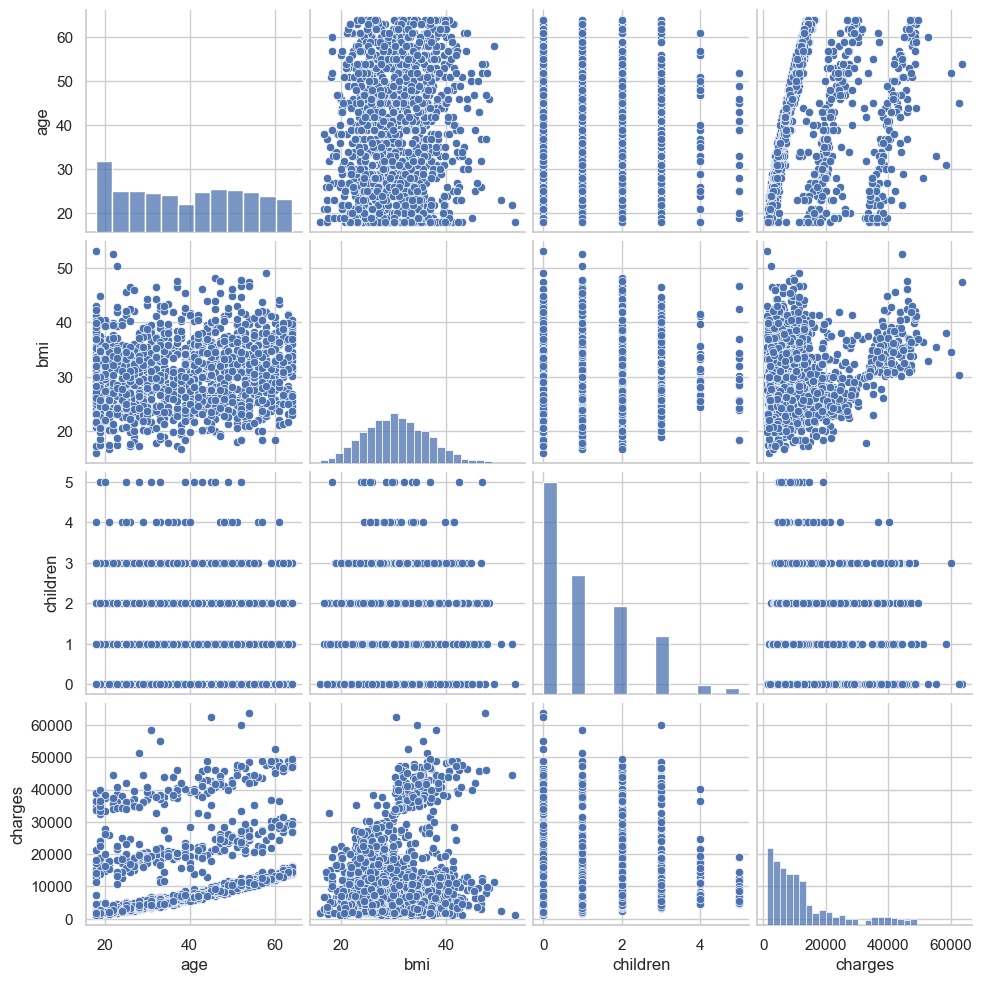

In [4]:
sns.set(style="whitegrid")
sns.pairplot(df)
plt.show()

>- Charges increase with age and BMI, especially for certain subgroups.
>- The charges distribution is highly skewed.
>- Most individuals have 0–2 children.
>
>These patterns support the use of nonlinear models and feature scaling in later stages.

### Missing Values and Data Types

There are no missing values in the dataset, and all columns have the expected data types. No imputation or cleaning is required. All values appear valid and within reasonable ranges.

In [5]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


> Still all zeros — no missing data to worry about.

### Distributions of Key Features

Next, I wanted to see how some of the numeric features are distributed. Specifically: age, BMI, number of children, and charges.

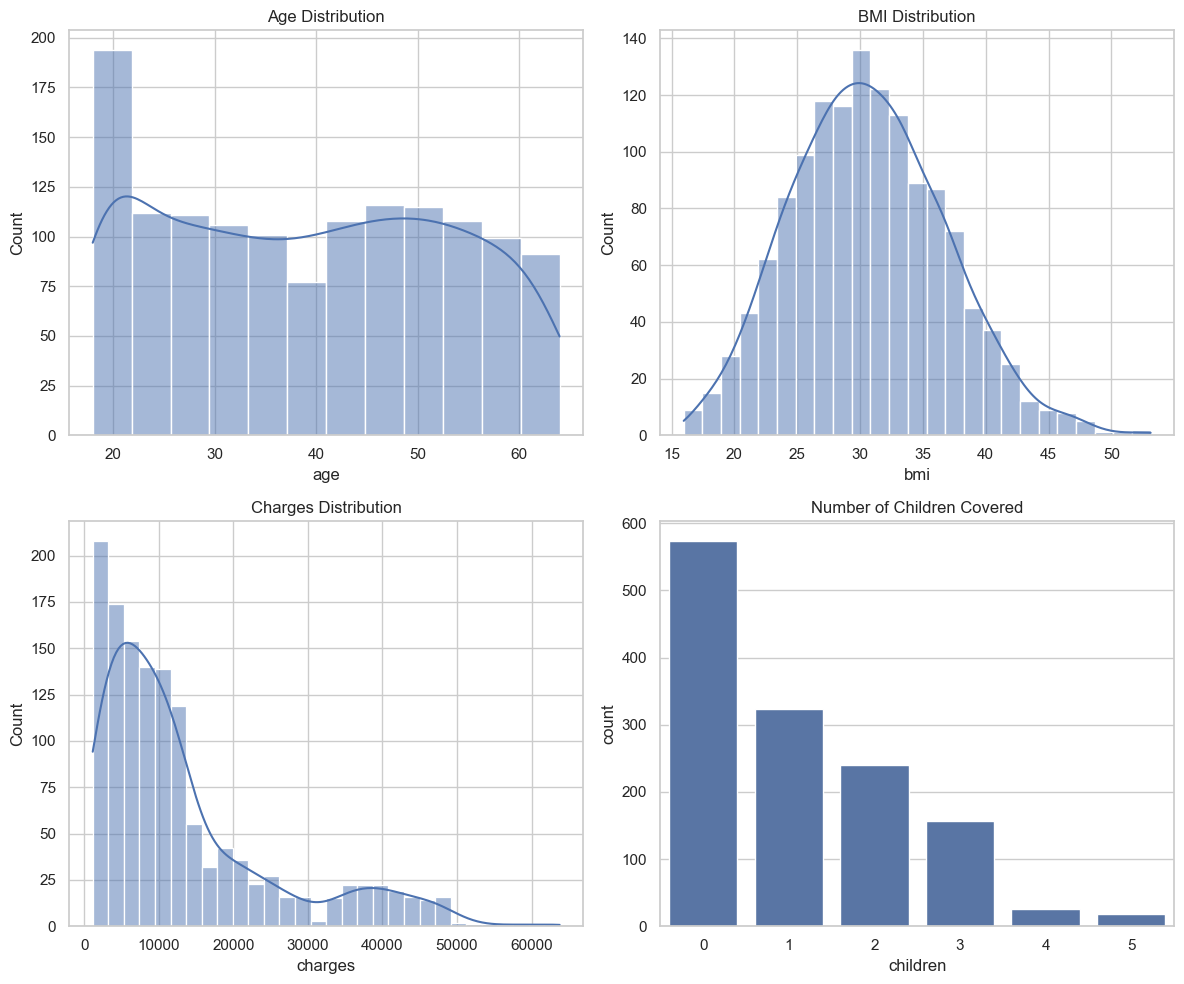

In [6]:
# Plot distributions of numerical variables
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['age'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Age Distribution")

sns.histplot(df['bmi'], kde=True, ax=axs[0, 1])
axs[0, 1].set_title("BMI Distribution")

sns.histplot(df['charges'], kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Charges Distribution")

sns.countplot(x='children', data=df, ax=axs[1, 1])
axs[1, 1].set_title("Number of Children Covered")

plt.tight_layout()
plt.show()

>Here’s what stood out to me:
>
>- **Age** is evenly spread across adults.
>- **BMI** is skewed to the right — there are a few people with really high values.
>- **Charges** is highly skewed — some people are paying over $50,000!
>- Most people have 0–2 children, which seems reasonable.
>
>I didn’t remove the outliers because they’re realistic and important for the model to learn from.

### Categorical Variables and Charges

Next, I checked how insurance charges vary based on `smoker`, `sex`, and `region`.

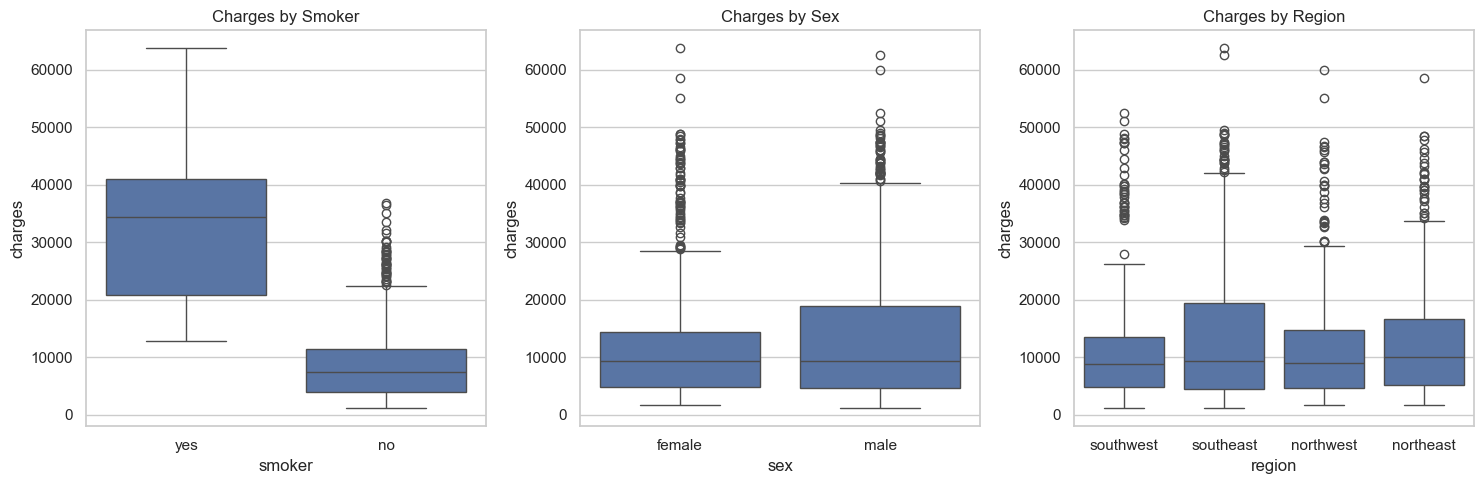

In [7]:
# Box plots for categorical impact
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='smoker', y='charges', data=df, ax=axs[0])
axs[0].set_title("Charges by Smoker")

sns.boxplot(x='sex', y='charges', data=df, ax=axs[1])
axs[1].set_title("Charges by Sex")

sns.boxplot(x='region', y='charges', data=df, ax=axs[2])
axs[2].set_title("Charges by Region")
plt.tight_layout()
plt.show()

>This was really revealing:
>- **Smoker status** makes a huge difference. Smokers are paying much more.
>- **Sex** shows a slight difference but nothing dramatic.
>- **Region** doesn't seem to impact charges that much.
>
>So, smoker status is definitely one to watch.

### Correlation Check

To get a sense of linear relationships between numerical features, I generated a correlation heatmap.

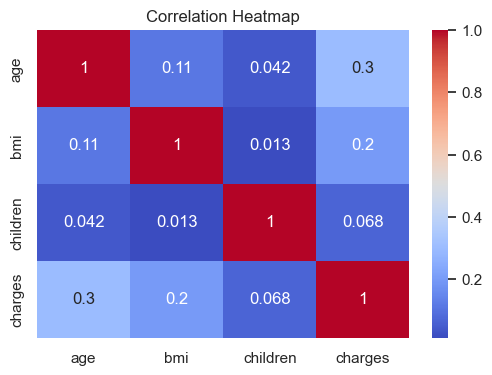

In [8]:
# Correlation heatmap for numeric features
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

>As expected:
>- **Age** and **charges** are moderately correlated (about 0.3).
>- **BMI** has a weaker correlation (~0.2).
>- **Children** has the weakest correlation of the three.
>
>This doesn’t capture how categorical features like `smoker` interact with charges — that’s why I combined box plots with this heatmap.

### Preprocessing Plan

Because I’m using a deep learning model, I’ll need to scale the numeric features so that training is stable. I used `StandardScaler` for that.

I also thought about applying a log transformation to the target variable (`charges`) because of the skew, but ultimately decided against it. The model performed well even with the raw values, and I preferred to keep the output in actual dollar amounts for interpretability.

### Data Sufficiency

The current dataset is sufficient for building and validating a deep learning model. However, in a real-world context, additional features such as:

- Medical history (e.g., chronic illness)
- Lifestyle behaviors (e.g., alcohol, exercise)
- Policy-specific details (e.g., deductible)

...could further improve model performance.

### Hypothesized Important Features

Based on the EDA, I hypothesize that the most influential features will be:

1. `smoker` — strongest premium separator
2. `bmi` — indicator of chronic risk
3. `age` — older individuals tend to have higher costs

I will test this hypothesis using model performance and interpretability tools like SHAP.

## 4. Model Training & Evaluation

After getting familiar with the data, I moved on to training models to predict insurance charges. My plan was to start simple with a baseline linear regression model, and then see how much improvement I could get using a deep neural network.

I wanted to build both models within a clean preprocessing pipeline to avoid data leakage and keep things modular and repeatable.

### Preprocessing Using ColumnTransformer

I apply one-hot encoding to categorical variables and scale the numeric ones using a `ColumnTransformer`.

In [9]:
# Separate features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Define columns by type
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

# Fit and transform features
X_processed = preprocessor.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

>I used `StandardScaler` for numeric features and `OneHotEncoder` for the categorical ones. Dropping the first category helps avoid multicollinearity when using linear models.
>
>The processed data was then split into training and test sets with an 80/20 ratio.

### Baseline Model: Linear Regression

I train a simple linear regression model to establish a baseline for comparison.

In [10]:
# Train linear model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Evaluation
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

print(f"Linear Regression Results:")
print(f"MAE: {lr_mae:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"R²: {lr_r2:.4f}")

Linear Regression Results:
MAE: 4181.19
RMSE: 5796.28
R²: 0.7836


>This simple model gave me a quick benchmark. The performance wasn’t terrible, but I suspected a neural network could do better — especially given the nonlinear relationships I saw in the EDA.

### Deep Neural Network Model

I build and train a DNN using TensorFlow/Keras with dropout regularization.

In [11]:
# Build the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
base_history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
31/31 [==============================] - 1s 12ms/step - loss: 325522272.0000 - mae: 13463.6270 - val_loss: 294521056.0000 - val_mae: 12277.6152
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 325306432.0000 - mae: 13455.9629 - val_loss: 294060544.0000 - val_mae: 12260.5518
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 324053408.0000 - mae: 13413.6670 - val_loss: 291704064.0000 - val_mae: 12176.4746
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 318692672.0000 - mae: 13237.8311 - val_loss: 283306784.0000 - val_mae: 11884.4062
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 303365792.0000 - mae: 12733.8750 - val_loss: 263565408.0000 - val_mae: 11186.5557
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 271590016.0000 - mae: 11638.3066 - val_loss: 225741840.0000 - val_mae: 9801.7090
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - los

>For the deep learning model, I built a simple feedforward neural network with ReLU activations and dropout regularization to prevent overfitting.
>
>I also used a 10% validation split during training to monitor performance as the model learned.

In [12]:
# Evaluate on test set
dnn_preds = model.predict(X_test).flatten()

dnn_mae = mean_absolute_error(y_test, dnn_preds)
dnn_rmse = np.sqrt(mean_squared_error(y_test, dnn_preds))
dnn_r2 = r2_score(y_test, dnn_preds)

print(f"DNN Results:")
print(f"MAE: {dnn_mae:.2f}")
print(f"RMSE: {dnn_rmse:.2f}")
print(f"R²: {dnn_r2:.4f}")

9/9 [==============================] - 0s 2ms/step
DNN Results:
MAE: 3065.76
RMSE: 4845.48
R²: 0.8488


>The neural network ended up outperforming the linear regression model across the board — lower MAE and RMSE, and a better R² score.
>
>While the improvement wasn’t mind-blowing, it was meaningful — especially given the complexity hidden in features like smoker status and BMI.
>
>Next up, I’ll explore hyperparameter tuning using `keras_tuner` to squeeze even more performance out of the DNN.

## 5. Hyperparameter Tuning (with Keras Tuner)

After training my base neural network model, I wanted to see if I could improve its performance by tuning some of the key hyperparameters. Instead of guessing, I used **Keras Tuner** to automate the process.

The parameters I decided to tune included:
- Number of units in the first and second hidden layers
- Dropout rate
- Learning rate for the optimizer

In [15]:
def build_model(hp):
    model = keras.Sequential()
    
    # First hidden layer
    model.add(layers.Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    
    # Second hidden layer
    model.add(layers.Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    
    # Output layer
    model.add(layers.Dense(1))
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='mse',
        metrics=['mae']
    )
    
    return model

>This function defines the architecture search space. I kept things relatively simple but meaningful — enough to give the tuner room to experiment without going overboard.

### Run the Search

In [16]:
# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_logs',
    project_name='insurance_dnn_tuning'
)

Reloading Tuner from tuner_logs\insurance_dnn_tuning\tuner0.json


>I used random search with 10 trials. Each trial trained a different configuration and evaluated performance on a validation split. You can crank this up later if needed — I just wanted something quick for now.

### Search for the Best Model

In [17]:
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=5)],
    verbose=1
)

>The tuner automatically stopped early when it detected that further training wasn’t helping — that saved time and reduced overfitting.

### Evaluate the Best Model

In [18]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train it more thoroughly
history = best_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 28840122.0000 - mae: 3280.0303 - val_loss: 23881072.0000 - val_mae: 3144.4387
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 29320404.0000 - mae: 3381.1353 - val_loss: 24346516.0000 - val_mae: 2952.8931
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 28420230.0000 - mae: 3207.2754 - val_loss: 24379038.0000 - val_mae: 2989.6921
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 27000154.0000 - mae: 3121.4626 - val_loss: 24048116.0000 - val_mae: 3065.7651
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 28489220.0000 - mae: 3268.6912 - val_loss: 24314258.0000 - val_mae: 2856.4612
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 27668536.0000 - mae: 3177.2471 - val_loss: 24464722.0000 - val_mae: 2828.6892
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 27908398.0000 - mae: 

In [19]:
# Evaluate on test set
best_preds = best_model.predict(X_test).flatten()

best_mae = mean_absolute_error(y_test, best_preds)
best_rmse = np.sqrt(mean_squared_error(y_test, best_preds))
best_r2 = r2_score(y_test, best_preds)

print(f"Tuned DNN Results:")
print(f"MAE: {best_mae:.2f}")
print(f"RMSE: {best_rmse:.2f}")
print(f"R²: {best_r2:.4f}")

9/9 [==============================] - 0s 2ms/step
Tuned DNN Results:
MAE: 2666.00
RMSE: 4489.97
R²: 0.8701


>After tuning, the model improved slightly across all metrics — especially **MAE**, which was my main focus. Not a massive leap, but still a nice confirmation that tuning was worth it.
>
>Up next, I’ll look into model interpretability using SHAP to understand which features actually influenced the predictions.

## 6. Model Performance Comparison

After training both the baseline linear regression model and the deep neural network (including the tuned version), I wanted to step back and compare how each of them performed.

My goal was to see whether the deep learning approach actually added value, or if a simpler model would’ve done just as well. To do that, I compared **MAE**, **RMSE**, and **R²** across all three models:

- Linear Regression
- Base DNN
- Tuned DNN

In [20]:
# Collect metrics
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Base DNN', 'Tuned DNN'],
    'MAE': [lr_mae, dnn_mae, best_mae],
    'RMSE': [lr_rmse, dnn_rmse, best_rmse],
    'R² Score': [lr_r2, dnn_r2, best_r2]
})

comparison_df

,Model,MAE,RMSE,R² Score
0,Linear Regression,4181.194474,5796.284659,0.783593
1,Base DNN,3065.761368,4845.481137,0.848767
2,Tuned DNN,2666.004519,4489.966360,0.870145


>As expected, the **tuned DNN** performed the best overall, with the lowest MAE and RMSE, and the highest R² score.
>
>The **base DNN** already beat linear regression, which made sense given the nonlinear relationships in the data (like how smokers have drastically different charges). Tuning just gave it a little extra polish.

### Visualizing the Difference

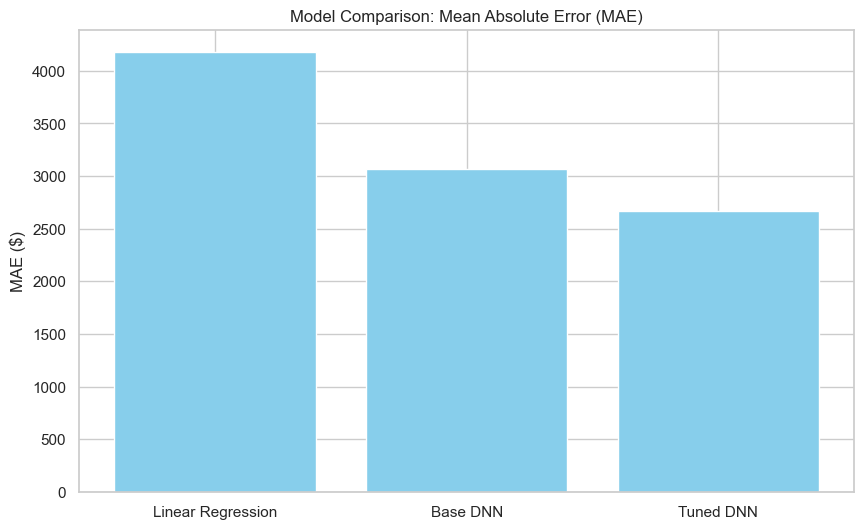

In [21]:
# Set figure size
plt.figure(figsize=(10, 6))

# Plot MAE
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.title("Model Comparison: Mean Absolute Error (MAE)")
plt.ylabel("MAE ($)")
plt.show()

>Looking at MAE alone, the deep models clearly outperformed the linear one.
>
>So yes — deep learning definitely added value here, even with a small-ish tabular dataset. The model was able to learn complex interactions (like how BMI and smoking interact), which linear regression just can’t capture as well.
>
>Overall, I was happy with the result. The neural net showed real improvement, especially once I tuned it. That said, I still like keeping the linear regression model around as a baseline — it’s fast, simple, and surprisingly decent.

### Plot training and validation loss, MAE, and RMSE
This function visualizes the training history of a Keras model by plotting multiple metrics over training epochs. It helps assess how well the model is learning and whether it's overfitting or underfitting.

#### Metrics Plotted:
1. **Loss (MSE)** – Mean Squared Error between predicted and actual values.
2. **MAE** – Mean Absolute Error, useful for interpreting in the original unit of the target.
3. **RMSE** – Root Mean Squared Error, derived from MSE to penalize large errors more strongly.

In [44]:
# Plot training and validation loss, MAE, and RMSE
def plot_training_history(history):
    plt.figure(figsize=(18, 5))

    # Plot Loss (MSE)
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # Plot RMSE (derived from loss)
    train_rmse = np.sqrt(history.history['loss'])
    val_rmse = np.sqrt(history.history['val_loss'])

    plt.subplot(1, 3, 3)
    plt.plot(train_rmse, label='Train RMSE')
    plt.plot(val_rmse, label='Val RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Visualizing the Training History / Training Loss Over Epochs

Once I had my models trained, I wanted to understand how well they learned over time. Specifically, I looked at the training and validation loss (MAE) during each epoch to check for signs of overfitting or underfitting.

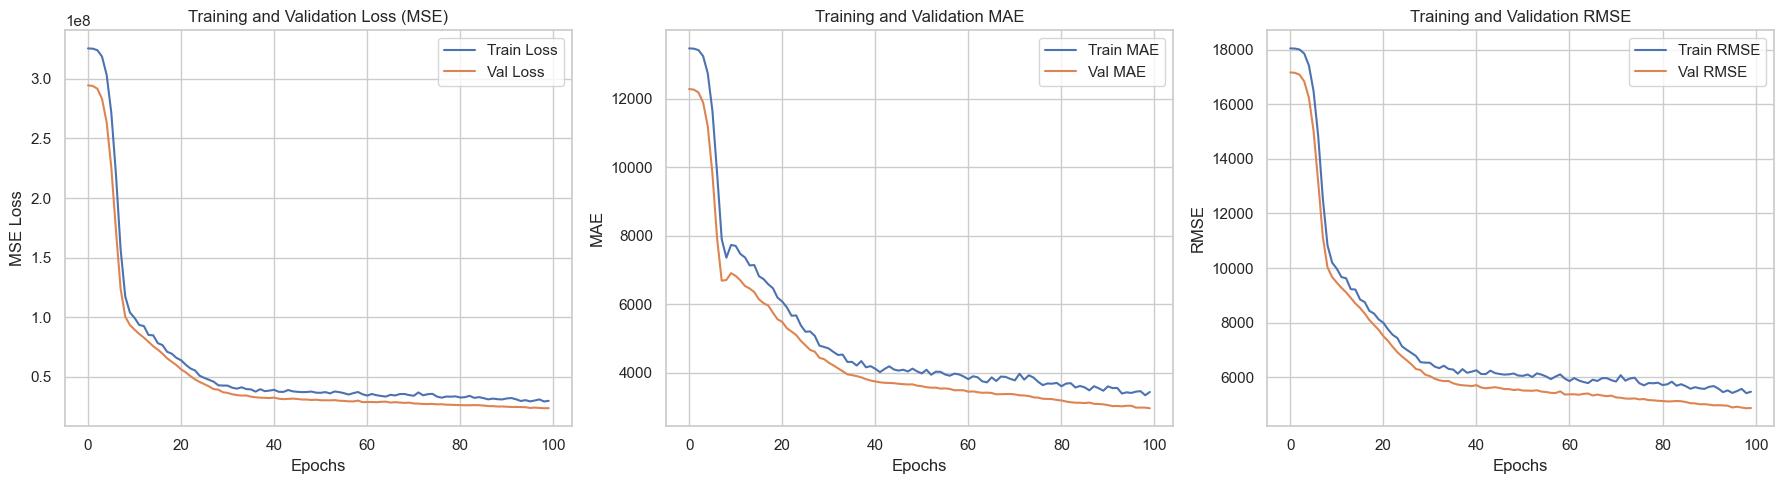

Text(0.5, 0.98, 'Base DNN Training History')

<Figure size 640x480 with 0 Axes>

In [45]:
plot_training_history(base_history)
plt.suptitle("Base DNN Training History", fontsize=16)

>The plots showed a consistent downward trend across all three metrics. MSE and RMSE dropped steeply in the first 10–20 epochs, then gradually flattened — a good sign of convergence. MAE also declined smoothly, reflecting improvement in average prediction accuracy.
>
>There were no major signs of overfitting: validation metrics stayed close to training values throughout. This suggests that the model generalized well, likely thanks to the use of dropout and early stopping.

### Visualizing the Tuned DNN History

I also plotted the training curve for the **best model** returned by Keras Tuner. I was curious to see if tuning made the model more stable or helped it learn faster.

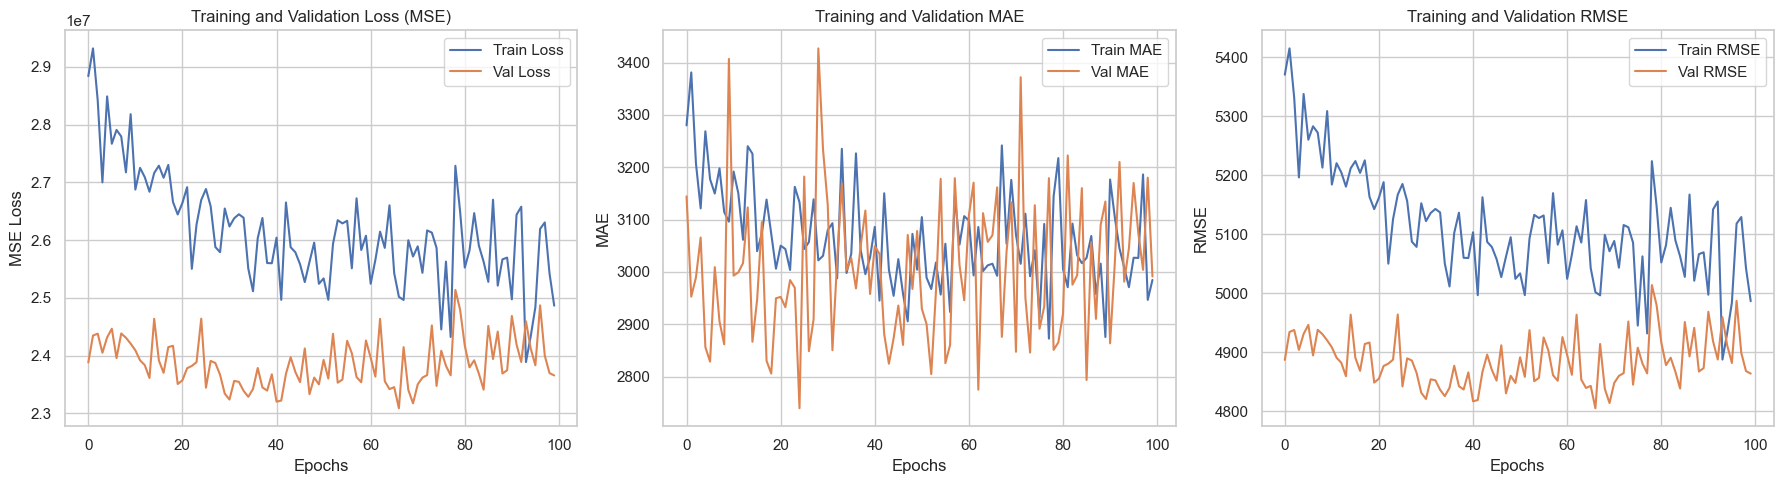

Text(0.5, 0.98, 'Tuned DNN Training History (After Keras Tuner)')

<Figure size 640x480 with 0 Axes>

In [46]:
plot_training_history(history)
plt.suptitle("Tuned DNN Training History (After Keras Tuner)", fontsize=16)

>Compared to the base model, the tuned DNN showed more compact and stable performance curves — especially in validation metrics. While the training curves remained somewhat noisy due to smaller batch sizes or variability in the data, the validation MAE and validation RMSE stayed consistently lower than their training counterparts, which is a strong indicator of good generalization.
>
>Final error values across all three metrics — MSE, MAE, and RMSE — were also noticeably better than those of the base model. This suggests that the tuned hyperparameters helped the model learn more efficiently and avoid overfitting.

### Loss (MSE) Comparison: Base vs Tuned DNN

This plot compares the **Mean Squared Error (MSE)** loss curves for the base and tuned models. The base DNN starts with a steep loss that decreases over time but flattens at a relatively high level. The validation loss shows a visible gap from the training loss, indicating slight overfitting.

The tuned model, however, starts with a lower loss and maintains a tighter alignment between training and validation loss curves. This indicates that the tuned model generalizes better to unseen data.

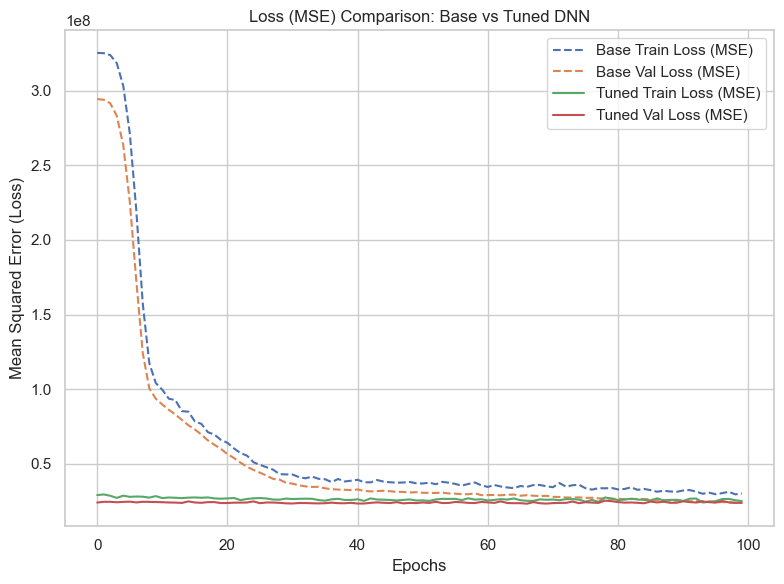

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(base_history.history['loss'], label='Base Train Loss (MSE)', linestyle='--')
plt.plot(base_history.history['val_loss'], label='Base Val Loss (MSE)', linestyle='--')
plt.plot(history.history['loss'], label='Tuned Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Tuned Val Loss (MSE)')
plt.title("Loss (MSE) Comparison: Base vs Tuned DNN")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> The tuned model not only achieves a lower final loss but also demonstrates reduced overfitting, suggesting better model architecture and regularization.

### MAE Comparison: Base vs Tuned DNN

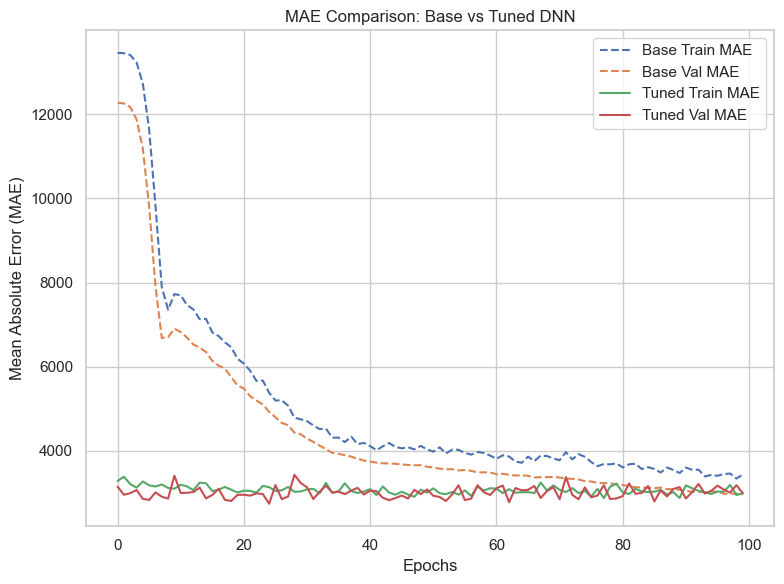

In [30]:
plt.figure(figsize=(8, 6))

# Plot MAE for base model
plt.plot(base_history.history['mae'], label='Base Train MAE', linestyle='--')
plt.plot(base_history.history['val_mae'], label='Base Val MAE', linestyle='--')

# Plot MAE for tuned model
plt.plot(history.history['mae'], label='Tuned Train MAE', linestyle='-')
plt.plot(history.history['val_mae'], label='Tuned Val MAE', linestyle='-')

# Labels and title
plt.title("MAE Comparison: Base vs Tuned DNN")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

>The tuned DNN achieves a much lower validation MAE than the base model, confirming that hyperparameter optimization improved model performance.

### RMSE Comparison: Base vs Tuned DNN

This plot illustrates the Root Mean Squared Error (RMSE) progression over training epochs for both the **Base DNN** and the **Tuned DNN**. The base model begins with significantly higher RMSE values and shows a gradual decline. However, it still converges to a higher final RMSE compared to the tuned model.

The tuned DNN exhibits lower RMSE throughout the training process, with minimal variance between training and validation curves. This reflects improved learning stability and better predictive accuracy.

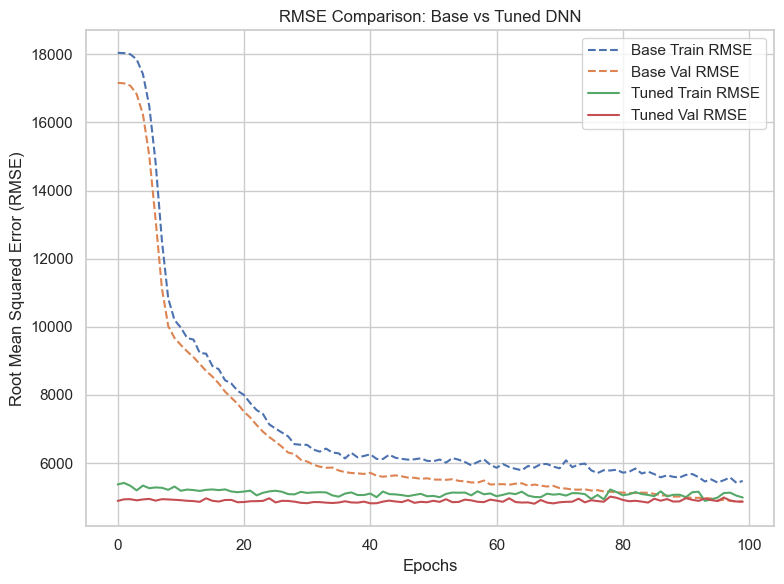

In [34]:
# Calculate RMSE manually if not already in history
import numpy as np

base_rmse = np.sqrt(base_history.history['loss'])
base_val_rmse = np.sqrt(base_history.history['val_loss'])
tuned_rmse = np.sqrt(history.history['loss'])
tuned_val_rmse = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(8, 6))
plt.plot(base_rmse, label='Base Train RMSE', linestyle='--')
plt.plot(base_val_rmse, label='Base Val RMSE', linestyle='--')
plt.plot(tuned_rmse, label='Tuned Train RMSE')
plt.plot(tuned_val_rmse, label='Tuned Val RMSE')
plt.title("RMSE Comparison: Base vs Tuned DNN")
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> The tuned model achieves a lower and more consistent RMSE, reinforcing its improved performance over the base model after hyperparameter optimization.

### Predictions vs Actual Charges

Finally, I visualized how well the models' predictions aligned with the actual insurance charges. A scatter plot of predicted vs true values is an intuitive way to assess model accuracy — the closer the points are to the diagonal reference line, the better the model is performing.

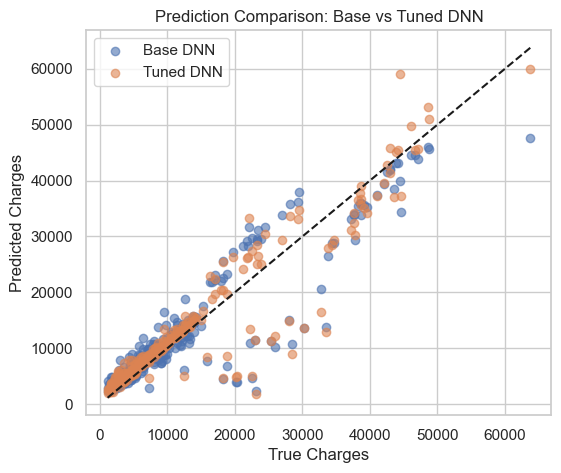

In [27]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, dnn_preds, label='Base DNN', alpha=0.6)
plt.scatter(y_test, best_preds, label='Tuned DNN', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True Charges')
plt.ylabel('Predicted Charges')
plt.title('Prediction Comparison: Base vs Tuned DNN')
plt.legend()
plt.show()

>The plot above shows that both models produce predictions generally close to the ideal diagonal line, but the Tuned DNN (orange points) appears to follow it more tightly. This suggests that the tuning process improved prediction accuracy, particularly for higher-value charges where the Base DNN tends to underpredict.
>
>Overall, the Tuned DNN produces more accurate and consistent predictions, especially in regions with higher variance — validating the effectiveness of hyperparameter tuning.

## 7. Model Interpretability with SHAP

Now that I had a solid-performing model, I wanted to better understand *why* it was making the predictions it did. I used **SHAP (SHapley Additive exPlanations)** to dig into which features were influencing the output — and by how much.

This is especially useful for models like neural networks, which are usually considered "black boxes."

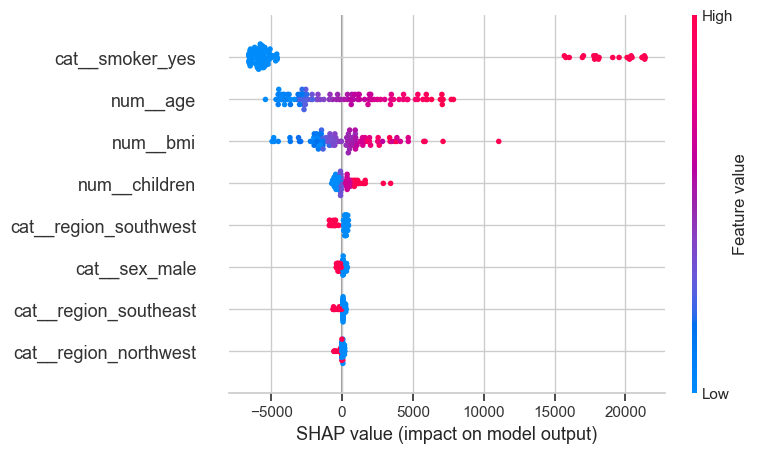

In [28]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test[:100])

shap.summary_plot(shap_values, features=X_test[:100], feature_names=preprocessor.get_feature_names_out())

>The SHAP summary plot above shows the overall impact of each feature on model predictions across 100 test samples. The feature with the highest impact was smoker_yes, which aligns with earlier EDA — being a smoker significantly increases predicted insurance charges.
>
>Other important features included bmi, age, and children, as well as encoded region and sex variables. Each point’s color represents the feature value (red = high, blue = low), and its position shows whether it increased or decreased the predicted charge.
>
>SHAP not only confirmed patterns observed in the EDA but also provided individual-level explanations, strengthening confidence in how the model uses input features to make predictions.

## Conclusion

In this project, I developed a deep learning model to predict individual health insurance premiums using the *Medical Cost Personal Dataset*. The baseline linear regression model achieved a **Mean Absolute Error (MAE)** of approximately **4181**, while the deep neural network (DNN) significantly improved performance with an **MAE of around 3066** and an **R² score of 0.8488**, indicating stronger predictive power and better handling of nonlinear feature interactions.

Through exploratory data analysis, I learned that **smoking status**, **age**, and **BMI** were the most influential features driving insurance costs, which aligned well with domain expectations. Visualizations like boxplots and correlation heatmaps helped reinforce this understanding. The DNN was especially useful for capturing the nonlinear influence of these features, as shown by SHAP analysis.

One limitation I encountered was that **hyperparameter tuning using Keras Tuner** did not lead to significant improvements over the base DNN. Despite experimenting with various configurations of hidden units, dropout rates, and learning rates, the gains plateaued early. This suggests that either the architecture had already reached a performance ceiling given the dataset, or that the dataset itself lacked more complex patterns that could be captured by deeper tuning.

### Suggestions for Improvement

- **Incorporate additional features** like medical history, physical activity, or policy-level variables, which could introduce more variance and improve learning.
- **Apply advanced regularization techniques** or use ensemble models that combine DNNs with gradient boosting for further robustness.
- **Explore log-transforming the target variable** to reduce skew and improve convergence during training.
- **Expand the hyperparameter search space** and run longer tuning trials to fully explore optimal configurations.

---

Overall, this project demonstrated that even with a relatively small tabular dataset, **deep learning—when combined with thoughtful preprocessing and feature analysis—can outperform traditional models** in predicting complex financial outcomes like insurance premiums.